In [1]:
import os
import glob

#data and math
import math
from math import e
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import datetime as dt
import uncertainties
from uncertainties import ufloat
from uncertainties.umath import *

#seawater property calculations
import seawater as sw
import geopy.distance

#plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm #colormap
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

%matplotlib inline
import seaborn as sns
import cmocean as cmo

In [2]:
# The lsqfitma.m matlab file (shown below) was adapted as a python function on 7/21/2021 by Rebecca Chmiel

# % Function to calculate a "2-way" least squares fit.
# %       x,y data are passed as vectors from another m-file.
# %       The line is fit by MINIMIZING the normal deviates.
# %       The equation of the line is:     y = mx + b
# %       This line is called the MAJOR AXIS.
# %       Equations are from York (1966) Canad. J. Phys. 44: 1079-1086;
# %            re-written from Kermack & Haldane (1950) Biometrika v37: 30-41;
# %            after a derivation by Pearson (1901) Phil. Mag. v2(6): 559-572.
# %
# %       Data returned are as follows:
# %
# %	 m,b,r,sm,sb,xbar,ybar = lsqfitma(x,y)
# %
# %               m    =    slope
# %               b    =    y-intercept
# %               r    =    correlation coefficient
# %               sm   =    standard deviation of the slope
# %               sb   =    standard deviation of the y-intercept
# %               xbar =    mean of x values
# %               ybar =    mean of y values
# %
# %       Note that (xbar,ybar) is the centroid

def lsqfitma(x,y):

    # % Determine the size of the vector
    n = len(x)
    
    # % Calculate sums and other re-used expressions
    Sx = sum(x)
    Sy = sum(y)
    xbar = Sx/n
    ybar = Sy/n
    u = x - xbar
    v = y - ybar
    Suv = sum(u * v)
    Su2 = sum(u ** 2)
    Sv2 = sum(v ** 2)
    sigx = math.sqrt(Su2/(n-1))
    sigy = math.sqrt(Sv2/(n-1))
    
    # % Calculate m, b, r, sm, and sb
    m = (Sv2 - Su2 + math.sqrt(((Sv2 - Su2)**2) + (4 * Suv**2)))/(2 * Suv)
    b = ybar - m * xbar
    r = Suv / math.sqrt(Su2 * Sv2)
    r2 = r**2
    sm = (m / r) * math.sqrt((1 - r2)/n)
    sb1 = (sigy - sigx *m)**2
    sb2 = (2* sigx * sigy) + ((xbar * m * (1+r))/ r2)
    sb = math.sqrt((sb1 + ((1-r) * m * sb2))/n)
    print('Count:', n, '\nSlope:', m, '+/-', sm, '\nIntercept:', b, '+/-', sb, '\nR2:', r2, '\n')
    return m,b,r,sm,sb,xbar,ybar

In [3]:
#import CSV file dCo_data_2-4-20.csv
df_data = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/ODV_2-4-20/dCo_data_5-20-2021_molarity_updated.csv')
df_data_dropna = df_data.dropna()
df_data = df_data.sort_values(['Station', 'CTDPRS [dbar]', 'dCo [pM]'])
df_data_dropna = df_data_dropna.sort_values(['Station', 'CTDPRS [dbar]'])

In [4]:
#only use points in the OMZ
x = 'CTDOXY [umol/kg]'
y = 'dCo [pM]'
z = 'DEPTH [m]'
O2_threshold = 200
depth_threshold = 150
df_OMZ = df_data[df_data[x] <= O2_threshold]
df_OMZ = df_OMZ.dropna(subset = [x, y, z])

# find average depths of each OMZ core by region
O2_threshold = 50
etsp_stns = [29, 34]
df_ETSP = df_OMZ[(df_OMZ['Station'] >= etsp_stns[0]) & (df_OMZ['Station'] <= etsp_stns[1]) & 
                    (df_OMZ['CTDOXY [umol/kg]'] <= O2_threshold)]
etnp_stns = [20, 25]
df_ETNP = df_OMZ[(df_OMZ['Station'] >= etnp_stns[0]) & (df_OMZ['Station'] <= etnp_stns[1]) &
                    (df_OMZ['CTDOXY [umol/kg]'] <= O2_threshold)]
NP_stns = [3,18]
df_NP = df_OMZ[(df_OMZ['Station'] >= NP_stns[0]) & (df_OMZ['Station'] <= NP_stns[1]) &
                (df_OMZ['CTDOXY [umol/kg]'] <= O2_threshold)]

#OMZ < 50 umol/kg O2
print('ETSP depth average: ', df_ETSP['DEPTH [m]'].mean(), '+/-', df_ETSP['DEPTH [m]'].std())
print('ETNP depth average: ', df_ETNP['DEPTH [m]'].mean(), '+/-', df_ETNP['DEPTH [m]'].std())
print('NP depth average: ', df_NP['DEPTH [m]'].mean(), '+/-', df_NP['DEPTH [m]'].std())

ETSP depth average:  347.14285714285717 +/- 99.02824549891513
ETNP depth average:  436.2857142857143 +/- 257.8911730611522
NP depth average:  954.3258426966293 +/- 423.43508076211697


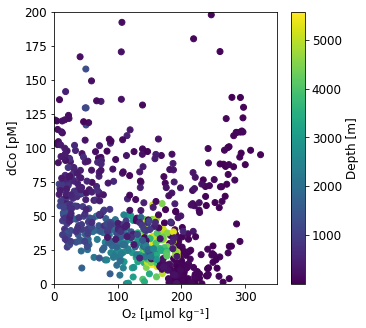

Count: 493 
Slope: -0.3174558012717323 +/- 0.027052092542756898 
Intercept: 80.01606450631249 +/- 1.2694618565913554 
R2: 0.218340970646361 



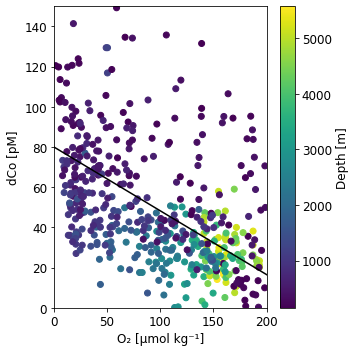

Count: 205 
Slope: -0.12377641929008294 +/- 0.037445004257741915 
Intercept: 59.1028143869822 +/- 1.7894395161304084 
R2: 0.05060364054972227 



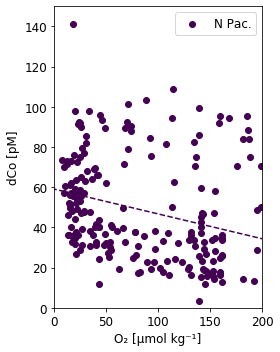

Count: 77 
Slope: -0.5219130123653715 +/- 0.05877060789299329 
Intercept: 91.25452037572873 +/- 2.8329343020124744 
R2: 0.5059778931104851 

Count: 71 
Slope: -0.5517772424558548 +/- 0.054363342067334716 
Intercept: 110.01029831527657 +/- 2.5119162256278647 
R2: 0.5919974310851732 



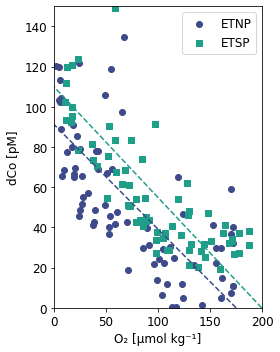

In [5]:
#dCo vs. O2 figure in OMZ

x = 'CTDOXY [umol/kg]'
y = 'dCo [pM]'
z = 'DEPTH [m]'
stn = 'Station'
xaxis_label = 'O\u2082 [\u03BCmol kg\u207B\u00B9]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Depth [m]'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'

#all points plot
plt.figure(figsize=(5, 5))
fig = plt.scatter(x, y, c=z, data=df_data, cmap=color_scheme)
# plt.plot([-intercept / slope, 0], [0, intercept], 'k-')
plt.ylim(0,200)
plt.xlim(0,350)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.show()

#only plot points in the OMZ
O2_threshold = 200
depth_threshold = 150
df_OMZ = df_data[df_data[x] <= O2_threshold]
df_OMZ = df_OMZ[df_OMZ[z]>= depth_threshold]
df_OMZ = df_OMZ.dropna(subset = [x, y, z])
x_array = np.array(df_OMZ[x])
y_array = np.array(df_OMZ[y])
slope, intercept, r_value, std_err, intercept_err, xbar, ybar = lsqfitma(x_array,y_array)

OMZ_names = ['all', 'N Pac.', 'ETNP', 'ETSP']
slope_list = []
slope_err_list = []
r2_list = []

plt.figure(figsize=(5, 5))
fig = plt.scatter(x, y, c=z, data=df_OMZ, cmap=color_scheme)
plt.plot([-intercept / slope, 0], [0, intercept], 'k-')
slope_list.append(slope)
slope_err_list.append(std_err)
r2_list.append(r_value**2)
plt.ylim(0,150)
plt.xlim(0,O2_threshold)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.tight_layout()
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/dCo_O2_bydepth', dpi=300)
plt.show()

#plot NP, ETNP and ETSP
ETNP_stns = [20, 25]
ETSP_stns = [29, 34]
NP_stns = [3, 18]
df_ETNP = df_OMZ[(df_OMZ[stn] >= ETNP_stns[0]) & (df_OMZ[stn]<= ETNP_stns[1])]
df_ETSP = df_OMZ[(df_OMZ[stn] >= ETSP_stns[0]) & (df_OMZ[stn]<= ETSP_stns[1])]
df_NP = df_OMZ[(df_OMZ[stn] >= NP_stns[0]) & (df_OMZ[stn]<= NP_stns[1])]
labels = ['N Pac.', 'ETNP', 'ETSP']
colors = ['#440154', '#3e4a89', '#1f9e89']
ylimit = [0,150]
xlimit = [0,O2_threshold]
dfs = [df_NP, df_ETNP, df_ETSP]

i=0
plt.figure(figsize=(4, 5))
plt.scatter(x, y, c=colors[i], data=dfs[i], cmap=color_scheme, label=labels[i])
x_array = np.array(dfs[i][x])
y_array = np.array(dfs[i][y])
slope, intercept, r_value, std_err, intercept_err, xbar, ybar = lsqfitma(x_array,y_array)
slope_list.append(slope)
slope_err_list.append(std_err)
r2_list.append(r_value**2)
plt.plot([-intercept / slope, 0], [0, intercept], '--', c=colors[i])
plt.ylim(ylimit)
plt.xlim(xlimit)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.legend(loc='best', fontsize=font_size)
plt.tight_layout()
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/dCo_O2_NP', dpi=300)
plt.show()

plt.figure(figsize=(4, 5))
i=1
plt.scatter(x, y, c=colors[i], data=dfs[i], cmap=color_scheme, label=labels[i], marker='o')
x_array = np.array(dfs[i][x])
y_array = np.array(dfs[i][y])
slope, intercept, r_value, std_err, intercept_err, xbar, ybar = lsqfitma(x_array,y_array)
slope_list.append(slope)
slope_err_list.append(std_err)
r2_list.append(r_value**2)
plt.plot([-intercept / slope, 0], [0, intercept], '--', c=colors[i])
i=2
plt.scatter(x, y, c=colors[i], data=dfs[i], cmap=color_scheme, label=labels[i], marker='s')
x_array = np.array(dfs[i][x])
y_array = np.array(dfs[i][y])
slope, intercept, r_value, std_err, intercept_err, xbar, ybar = lsqfitma(x_array,y_array)
slope_list.append(slope)
slope_err_list.append(std_err)
r2_list.append(r_value**2)
plt.plot([-intercept / slope, 0], [0, intercept], '--', c=colors[i])
plt.ylim(ylimit)
plt.xlim(xlimit)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.legend(loc='best', fontsize=font_size)
plt.tight_layout()
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/dCO_O2_ETNP_ETSP', dpi=300)
plt.show()

In [11]:
#calculate deoxygenation parameters

#put dCo:O2 slopes from GP15 OMZs into +- error format [umol dCo mol-1 O2 kg-1]
dCo_O2_slope_uncertainties = []
OMZ_names = ['all', 'N Pac.', 'ETNP', 'ETSP']
i=0
for point in slope_list:
    uncertainty = ufloat(slope_list[i], slope_err_list[i])
    dCo_O2_slope_uncertainties.append(uncertainty)
    i=i+1

#put O2 loss per year from Stramma 2008 into +- error format [umol O2 kg-1 year-1]
area_D_O2_loss_rate = ufloat(-0.13, 0.32)
area_E_O2_loss_rate = ufloat(-0.19, 0.20)
NPac_O2_loss_rate_range = [-0.39, -0.70]

#calculate pmol dCo added per L per year due to oxygenation [pM dCo yr-1]
#ETNP and area E
ETNP_dCo_added_E = dCo_O2_slope_uncertainties[2] * area_E_O2_loss_rate  
ETNP_dCo_added_D = dCo_O2_slope_uncertainties[2] * area_D_O2_loss_rate  
print('ETNP: {:.3P}' .format(ETNP_dCo_added_E), '- {:.3P}' .format(ETNP_dCo_added_D))
#ETSP and area E
ETSP_dCo_added_E = dCo_O2_slope_uncertainties[3] * area_E_O2_loss_rate
ETSP_dCo_added_D = dCo_O2_slope_uncertainties[3] * area_D_O2_loss_rate  
print('ETSP: {:.3P}' .format(ETSP_dCo_added_E), '- {:.3P}' .format(ETSP_dCo_added_D))
#N Pac OMZ and N Pac O2 loss
NP_dCo_added_min = dCo_O2_slope_uncertainties[1] * NPac_O2_loss_rate_range[0]
NP_dCo_added_max = dCo_O2_slope_uncertainties[1] * NPac_O2_loss_rate_range[1]
print('NP: {:.2P}' .format(NP_dCo_added_min), ' - {:.2P}' .format(NP_dCo_added_max))
#GP16 ETSP O2 loss
GP16_dCo_O2_slope = -0.33 * 1.025 #estimate to put into units of uM:mol kg-1
GP16_dCo_added_E = GP16_dCo_O2_slope * area_E_O2_loss_rate
GP16_dCo_added_D = GP16_dCo_O2_slope * area_D_O2_loss_rate
print('GP16 ETSP: {:.3P}' .format(GP16_dCo_added_E), '- {:.3P}' .format(GP16_dCo_added_D))
print('GP16 dCo:O2 slope converstion', GP16_dCo_O2_slope, 'umol:mol kg-1')

ETNP: 0.099±0.105 - 0.068±0.167
ETSP: 0.105±0.111 - 0.072±0.177
NP: 0.048±0.015  - 0.087±0.026
GP16 ETSP: 0.0643±0.0677 - 0.044±0.108
GP16 dCo:O2 slope converstion -0.33825 umol:mol kg-1


In [56]:
#dCo inventory in the top 1000 m

ETNP_stns = [20, 25]
ETSP_stns = [29, 34]

#calculate the volume of each OMZ transect (inventories are transects 1m3 wide)
ETNP_lat_range = [14.25156, 4.99977]
ETSP_lat_range = [0.00276, -7.50002]
long = -152
depth_integrated = 1000
O2_threshold = 200

ETNP_lat_distance_km = geopy.distance.distance([ETNP_lat_range[0], long], [ETNP_lat_range[1], long]).km
ETSP_lat_distance_km = geopy.distance.distance([ETSP_lat_range[0], long], [ETSP_lat_range[1], long]).km
ETNP_lat_distance = ETNP_lat_distance_km * 1000
ETSP_lat_distance = ETSP_lat_distance_km * 1000
ETNP_volume = ETNP_lat_distance * depth_integrated
ETSP_volume = ETSP_lat_distance * depth_integrated

#trapezoidal integration of each station in the OMZs
z = 'DEPTH [m]'
dCo = 'dCo [pM]'
stn = 'Station'
lat = 'Latitude'

dCo_areas_bystn = []

#define OMZ dfs
df_OMZ = df_data[df_data[x] <= O2_threshold]
df_OMZ = df_OMZ.dropna(subset = [dCo])
df_OMZ = df_OMZ.reset_index()
df_ETNP = df_OMZ[(df_OMZ['Station'] >= ETNP_stns[0]) & (df_OMZ['Station'] <= ETNP_stns[1])]
df_ETSP = df_OMZ[(df_OMZ['Station'] >= ETSP_stns[0]) & (df_OMZ['Station'] <= ETSP_stns[1])]
dfs = [df_ETNP, df_ETSP]

i=0
for df in dfs:
    df_upper = df[df[z] <= depth_integrated]
    stns_list = df[stn].unique().tolist()
    lat_list = df[lat].unique().tolist()
    j=0
    for stns in stns_list:
        df_stn = df_upper[df_upper[stn] == stns_list[j]]
        z_list = df_stn[z].unique().tolist()
        stn_lat = lat_list[j]
#         print(stns, z_list)
        #trapezoidal integration if there is a depth at 1000m
        if z_list[-1] == depth_integrated:
            for index, row in df_stn.head(n=df_stn[stn].count()).iterrows():
                #surface - 2 m integration:
                if df_stn[z][index] == z_list[0]:
                    h = df_stn[z][index]
                    dCo_avg = df_stn[dCo][index]
                    dCo_area = h* dCo_avg
                    dCo_areas_bystn.append([stns_list[j], stn_lat, 0, df_stn[z][index], dCo_area])
                #all other integration
                else:
                    h = df_stn[z][index] - df_stn[z][index-1]                    
                    dCo_avg = (df_stn[dCo][index] + df_stn[dCo][index-1])/2
                    dCo_area = h * dCo_avg 
                    dCo_areas_bystn.append([stns_list[j], stn_lat, df_stn[z][index-1], df_stn[z][index], dCo_area])
        #trapezoidal integration if there is no depth at 1000m
        else: 
            #identify the points above and below 1000m
            df_below = dfs[i][(dfs[i][stn] == stns_list[j]) & (dfs[i][z] > depth_integrated)]
            below_z_list = df_below[z].unique().tolist()
            below_z = below_z_list[0]
            df_below_point = df_below[df_below[z] == below_z]
            above_z = z_list[-1]
            df_above_point = df_stn[df_stn[z] == above_z]
            above_point = [df_above_point[dCo].iloc[0], above_z]
            below_point = [df_below_point[dCo].iloc[0], below_z]
            #find line between above and below depths
            slope = (above_point[1] - below_point[1]) / (above_point[0] - below_point[0])
            y_int = (above_point[1] - (slope * above_point[0]))
            #find interpolated value of dCo at 1000m to use as bottom of trapezoid
            at_1000 = ((depth_integrated - y_int) / slope)
            dCo_point_1000 = [at_1000, depth_integrated]
            #calculate area of trapezoid
            for index, row in df_stn.head(n=df_stn[stn].count()).iterrows():
                #surface - 2 m integration:
                if df_stn[z][index] == z_list[0]:
                    h = df_stn[z][index]
                    dCo_avg = df_stn[dCo][index]
                    dCo_area = h* dCo_avg
                    dCo_areas_bystn.append([stns_list[j], stn_lat, 0, df_stn[z][index], dCo_area])
                #calculate area of middle trapezoids
                else: 
                    h = df_stn[z][index] - df_stn[z][index-1]                    
                    dCo_avg = (df_stn[dCo][index] + df_stn[dCo][index-1])/2
                    dCo_area = h * dCo_avg 
                    dCo_areas_bystn.append([stns_list[j], stn_lat, df_stn[z][index-1], df_stn[z][index], dCo_area])
                #calculate area of bottom trapezoid
                if df_stn[z][index] == z_list[-1]:
                    h = dCo_point_1000[1] - df_stn[z][index]
                    dCo_avg = (df_stn[dCo][index] + dCo_point_1000[0])/2
                    dCo_area = h*dCo_avg
                    dCo_areas_bystn.append([stns_list[j], stn_lat, df_stn[z][index], dCo_point_1000[1], dCo_area])
        j=j+1
    i=i+1
    
df_dCo_areas = pd.DataFrame(dCo_areas_bystn, columns = ['Station', 'Latitude', 'Top Depth', 'Bottom Depth', 'Area [pM m]'])
dCo_stn_sums = []
dCo_stn_n = []

#calculate the total area inventory for each station 
stn_list = df_dCo_areas[stn].unique().tolist()
lat_list = df_dCo_areas[lat].unique().tolist()
i=0
for stns in stn_list:
    df_stn = df_dCo_areas[df_dCo_areas[stn] == stn_list[i]]
    stn_sum = df_stn['Area [pM m]'].sum()
    stn_n = df_stn['Area [pM m]'].count()
    dCo_stn_sums.append(stn_sum)
    dCo_stn_n.append(stn_n)
    i=i+1
df_areas = pd.DataFrame(list(zip(stn_list, lat_list, dCo_stn_sums, dCo_stn_n)), 
                       columns = ['Station', 'Latitude', 'dCo sum [pM m]', 'dCo n'])

#trapezoidal integration of OMZ inventories over latitude
ETNP_stns = [20, 25]
ETSP_stns = [29, 34]
df_ETNP_areas = df_areas[(df_areas[stn] >= ETNP_stns[0]) & (df_areas[stn] <= ETNP_stns[1])]
df_ETSP_areas = df_areas[(df_areas[stn] >= ETSP_stns[0]) & (df_areas[stn] <= ETSP_stns[1])]
dfs = [df_ETNP_areas, df_ETSP_areas]

OMZ_integrated_area_list = []
OMZ_integrated_inventory_list_nmol = []
i = 0
for df in dfs:
    lat_list = df[lat].unique().tolist()
    lat_integrated_area = []
    for index, row in df.head(n=df[stn].count()).iterrows():
        #exclude the last stn for each OMZ:
        if df[lat][index] == lat_list[-1]:
            pass
        else:
#             h_degrees = df[lat][index] - df[lat][index+1]
            h_km = geopy.distance.distance([df[lat][index], long], [df[lat][index+1], long]).km    
            h_m = h_km *1000                                                                       
            inventory_avg = (df['dCo sum [pM m]'][index] + df['dCo sum [pM m]'][index+1])/2
            inventory_area = h*inventory_avg
            lat_integrated_area.append(inventory_area)
    OMZ_integrated_area = sum(lat_integrated_area) 
    OMZ_integrated_area_list.append(OMZ_integrated_area)
    OMZ_integrated_inventory = OMZ_integrated_area * depth_integrated 
    OMZ_integrated_inventory_list_nmol.append(OMZ_integrated_inventory)
    i=i+1

ETNP_inventory_mol = OMZ_integrated_inventory_list_nmol[0] / 1000000000
ETSP_inventory_mol = OMZ_integrated_inventory_list_nmol[1] / 1000000000

print('ETNP Inventory [mol]:', round(ETNP_inventory_mol, 1))
print('ETSP Inventory [mol]:', round(ETSP_inventory_mol, 1))

df_areas

ETNP Inventory [mol]: 51.6
ETSP Inventory [mol]: 38.0


,Station,Latitude,dCo sum [pM m],dCo n
0,20.0,14.25156,72363.186825,12
1,21.0,11.00004,65819.950052,16
2,22.0,9.24929,67628.878502,13
3,23.0,7.50021,58696.837325,12
4,25.0,4.99977,59739.837017,16
5,29.0,0.00276,57383.155091,19
6,31.0,-2.50037,70023.381806,18
7,33.0,-5.00043,67539.761016,15
8,34.0,-7.50002,47185.576555,13


In [62]:
#Calculate % increase from deoxygenation

#calculate mol Co increase in 50 years
ETNP_rate = [ETNP_dCo_added_D, ETNP_dCo_added_E]   #pmol dCo L-1 yr-1
ETSP_rate = [ETSP_dCo_added_D, ETSP_dCo_added_E]
OMZ_rates = [ETNP_rate, ETSP_rate]
volumes = [ETNP_volume, ETSP_volume]
OMZ_ids = ['ETNP D', 'ETNP E', 'ETSP D', 'ETSP E']
dCo_increase_100yr_list = []

i=0
for OMZ in OMZ_rates:
    dCo_increase_peryear = [element * volumes[i] / 1000000000 for element in OMZ]    #mol Co yr-1
    dCo_increase_100yr = [element * 100 for element in OMZ]                          #mol Co
    dCo_increase_100yr_list.append(dCo_increase_100yr)
    i=i+1

print('100 yr ETNP increase [mol]:', dCo_increase_100yr_list[0][0], '-', dCo_increase_100yr_list[0][1])
print('100 yr ETSP increase [mol]:', dCo_increase_100yr_list[1][0], '-', dCo_increase_100yr_list[1][1])

#calculate % increases
ETNP_inventory_100yr = [ETNP_inventory_mol + dCo_increase_100yr_list[0][0], ETNP_inventory_mol + dCo_increase_100yr_list[0][1]]
ETSP_inventory_100yr = [ETSP_inventory_mol + dCo_increase_100yr_list[1][0], ETSP_inventory_mol + dCo_increase_100yr_list[1][1]]
ETNP_percent_increase = [dCo_increase_100yr_list[0][0] / ETNP_inventory_mol * 100, 
                         dCo_increase_100yr_list[0][1] / ETNP_inventory_mol * 100]
ETSP_percent_increase = [dCo_increase_100yr_list[1][0] / ETSP_inventory_mol * 100, 
                         dCo_increase_100yr_list[1][1] / ETSP_inventory_mol * 100]

print('ETNP 100 yr inventory [mol]:', ETNP_inventory_100yr[0], '-', ETNP_inventory_100yr[1])
print('ETSP 100 yr inventory [mol]:', ETSP_inventory_100yr[0], '-', ETSP_inventory_100yr[1])
print('ETNP 100 yr % increase:', ETNP_percent_increase[0], '-', ETNP_percent_increase[1])
print('ETSP 100 yr % increase:', ETSP_percent_increase[0], '-', ETSP_percent_increase[1])
ETSP_percent_increase

100 yr ETNP increase [mol]: 7+/-17 - 10+/-10
100 yr ETSP increase [mol]: 7+/-18 - 10+/-11
ETNP 100 yr inventory [mol]: 58+/-17 - 62+/-10
ETSP 100 yr inventory [mol]: 45+/-18 - 48+/-11
ETNP 100 yr % increase: 13+/-32 - 19+/-20
ETSP 100 yr % increase: (2+/-5)e+01 - 28+/-29


[18.891752130763205+/-46.54000906003124, 27.6110223449616+/-29.191265939637127]